# VAE for MNIST

The goal of this notebook is to explore the basic VAE architecture, with MNIST dataset.

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
from utils import *

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [ ]:
batch_size = 128

data_dir = 'data'
# MNIST dataset
dataset = torchvision.datasets.MNIST(root=data_dir,
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



# Variational Autoencoders

Consider a latent variable model with a data variable $x\in \mathcal{X}$ and a latent variable $z\in \mathcal{Z}$, $p(z,x) = p(z)p_\theta(x|z)$. Given the data $x_1,\dots, x_n$, we want to train the model by maximizing the marginal log-likelihood:
\begin{eqnarray*}
\mathcal{L} = \mathbf{E}_{p_d(x)}\left[\log p_\theta(x)\right]=\mathbf{E}_{p_d(x)}\left[\log \int_{\mathcal{Z}}p_{\theta}(x|z)p(z)dz\right],
  \end{eqnarray*}
  where $p_d$ denotes the empirical distribution of $X$: $p_d(x) =\frac{1}{n}\sum_{i=1}^n \delta_{x_i}(x)$.

 To avoid the (often) difficult computation of the integral above, the idea behind variational methods is to instead maximize a lower bound to the log-likelihood:
  \begin{eqnarray*}
\mathcal{L} \geq L(p_\theta(x|z),q(z|x)) =\mathbf{E}_{p_d(x)}\left[\mathbf{E}_{q(z|x)}\left[\log p_\theta(x|z)\right]-\mathrm{KL}\left( q(z|x)||p(z)\right)\right].
  \end{eqnarray*}
  Any choice of $q(z|x)$ gives a valid lower bound. Variational autoencoders replace the variational posterior $q(z|x)$ by an inference network $q_{\phi}(z|x)$ that is trained together with $p_{\theta}(x|z)$ to jointly maximize $L(p_\theta,q_\phi)$.
  
The variational posterior $q_{\phi}(z|x)$ is also called the **encoder** and the generative model $p_{\theta}(x|z)$, the **decoder** or generator.

The first term $\mathbf{E}_{q(z|x)}\left[\log p_\theta(x|z)\right]$ is the negative reconstruction error. Indeed under a gaussian assumption i.e. $p_{\theta}(x|z) = \mathcal{N}(\mu_{\theta}(z), I)$ the term $\log p_\theta(x|z)$ reduces to $\propto \|x-\mu_\theta(z)\|^2$, which is often used in practice. The term $\mathrm{KL}\left( q(z|x)||p(z)\right)$ can be seen as a regularization term, where the variational posterior $q_\phi(z|x)$ should be matched to the prior $p(z)= \mathcal{N}(0, I)$.

Variational Autoencoders were introduced by [Kingma and Welling (2013)](https://arxiv.org/abs/1312.6114), see also [(Doersch, 2016)](https://arxiv.org/abs/1606.05908) for a tutorial.

There are various examples of VAE in PyTorch available [here](https://github.com/pytorch/examples/tree/master/vae) or [here](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/variational_autoencoder/main.py#L38-L65). The code below is taken from this last source.

In [ ]:
# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 15
learning_rate = 1e-3

# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h) # mu(mean of q(z|x)) & log variance
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std) # generate standard gaussian variable
        return mu + eps * std # make backpropa possible

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Here for the loss, instead of MSE for the reconstruction loss, we take Binary Cross-Entropy.

In [ ]:
# Start training
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence between Gaussians, see Appendix B in VAE paper or (Doersch, 2016):
        # https://arxiv.org/abs/1606.05908
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size, kl_div.item()/batch_size))

Epoch[1/15], Step [10/469], Reconst Loss: 287.6225, KL Div: 20.7124
Epoch[1/15], Step [20/469], Reconst Loss: 227.0495, KL Div: 8.9412
Epoch[1/15], Step [30/469], Reconst Loss: 206.7588, KL Div: 9.5577
Epoch[1/15], Step [40/469], Reconst Loss: 211.6969, KL Div: 5.6808
Epoch[1/15], Step [50/469], Reconst Loss: 210.6502, KL Div: 5.8762
Epoch[1/15], Step [60/469], Reconst Loss: 191.6563, KL Div: 7.7532
Epoch[1/15], Step [70/469], Reconst Loss: 190.9541, KL Div: 6.8097
Epoch[1/15], Step [80/469], Reconst Loss: 189.8432, KL Div: 7.6357
Epoch[1/15], Step [90/469], Reconst Loss: 173.4683, KL Div: 9.7482
Epoch[1/15], Step [100/469], Reconst Loss: 169.1993, KL Div: 12.2292
Epoch[1/15], Step [110/469], Reconst Loss: 159.0145, KL Div: 11.6794
Epoch[1/15], Step [120/469], Reconst Loss: 157.9784, KL Div: 13.2347
Epoch[1/15], Step [130/469], Reconst Loss: 156.4386, KL Div: 14.3911
Epoch[1/15], Step [140/469], Reconst Loss: 148.3826, KL Div: 13.9872
Epoch[1/15], Step [150/469], Reconst Loss: 146.8124

Let see how our network reconstructs our last batch. We display pairs of original digits and reconstructed version.

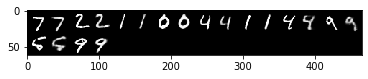

In [ ]:
plot_reconstruction(model, test_loader)

Let's see now how our network generates new samples.

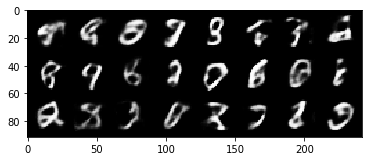

In [ ]:
plot_generation(model)

# Cheating with the 'conditional' VAE

Use labels in CVAE. The idea is to modify slightly the architecture above by feeding a onehot version of the label to the decoder in addition to the code computed by the encoder. 

First code a function transforming a label in its onehot encoding. This function will be used in the training loop (not in the architecture of the neural network).

In [ ]:
n_classes = 10
def l_2_onehot(labels,nb_digits=n_classes):
    # take labels (from the dataloader) and return labels onehot-encoded
    label_onehot = torch.FloatTensor(labels.shape[0], nb_digits)
    label_onehot.zero_()
    label_onehot.scatter_(1, labels.view(-1,1), 1)
    label_onehot = label_onehot.to(device)
    return label_onehot


Test it on a batch.

In [ ]:
(x,labels) = next(iter(data_loader))

In [ ]:
labels

tensor([9, 5, 5, 4, 7, 2, 5, 0, 3, 3, 2, 1, 8, 8, 7, 8, 4, 6, 8, 1, 8, 3, 5, 6,
        8, 2, 5, 7, 6, 2, 4, 7, 6, 3, 0, 3, 8, 0, 8, 9, 5, 3, 5, 4, 9, 5, 8, 2,
        7, 2, 7, 7, 5, 8, 8, 1, 7, 1, 3, 5, 4, 0, 1, 5, 0, 0, 4, 2, 1, 8, 2, 8,
        3, 0, 2, 2, 5, 7, 6, 9, 5, 0, 9, 5, 4, 1, 2, 0, 0, 1, 0, 0, 7, 4, 1, 0,
        6, 9, 8, 2, 2, 1, 4, 8, 6, 4, 0, 4, 0, 4, 1, 8, 5, 0, 1, 1, 0, 9, 8, 3,
        2, 1, 9, 7, 4, 7, 0, 1])

In [ ]:
l_2_onehot(labels)

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

Modifiy the architecture of the VAE where the decoder takes as input the random code concatenated with the onehot encoding of the label.

In [ ]:
n_classes = 10

class VAE_Cond(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20, n_classes = 10):
        super(VAE_Cond, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim+n_classes, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, l_onehot):
        h = F.relu(self.fc4(torch.cat([z, l_onehot], 1)))
        return torch.sigmoid(self.fc5(h))
    
    def forward(self, x, l_onehot):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z, l_onehot)
        return x_reconst, mu, log_var

Test new model on a batch:

In [ ]:
model_C = VAE_Cond().to(device)
x = x.to(device).view(-1, image_size)
l_onehot = l_2_onehot(labels)
l_onehot = l_onehot.to(device)
model_C(x, l_onehot)

(tensor([[0.5413, 0.4540, 0.4643,  ..., 0.4632, 0.4282, 0.5437],
         [0.5500, 0.4739, 0.4902,  ..., 0.5043, 0.5753, 0.4741],
         [0.5476, 0.4753, 0.4255,  ..., 0.4936, 0.4568, 0.5365],
         ...,
         [0.6465, 0.4030, 0.5112,  ..., 0.5541, 0.4237, 0.3453],
         [0.5140, 0.4379, 0.4640,  ..., 0.4667, 0.5263, 0.5160],
         [0.5695, 0.4878, 0.4878,  ..., 0.4982, 0.5153, 0.3975]],
        grad_fn=<SigmoidBackward0>),
 tensor([[ 0.0527, -0.0057,  0.0176,  ..., -0.1213, -0.0830,  0.0289],
         [-0.0377,  0.0336, -0.0020,  ..., -0.0470, -0.0542, -0.0320],
         [-0.1222,  0.0516,  0.0094,  ..., -0.1855, -0.0213, -0.0351],
         ...,
         [-0.0303,  0.0853,  0.0057,  ..., -0.1040, -0.0312,  0.0507],
         [-0.0361, -0.0038, -0.0183,  ..., -0.1199, -0.0122,  0.0309],
         [ 0.0103, -0.0149,  0.0177,  ..., -0.1482, -0.0880, -0.0098]],
        grad_fn=<AddmmBackward0>),
 tensor([[ 0.0413, -0.1121, -0.1722,  ...,  0.0987,  0.0411,  0.0468],
         [-

Modify the training loop of network. The parameter $\beta$ allows to scale the KL term in the loss as explained in the [$\beta$-VAE paper](https://openreview.net/forum?id=Sy2fzU9gl) see formula (4) in the paper.

In [ ]:
def train_C(model, data_loader=data_loader,num_epochs=num_epochs, beta=10., verbose=True):
    nmi_scores = []
    model.train(True)
    for epoch in range(num_epochs):
        for i, (x, labels) in enumerate(data_loader):
            # Forward pass
            x = x.to(device).view(-1, image_size)
            label_onehot = l_2_onehot(labels)
            x_reconst, mu, log_var = model(x, label_onehot)
            
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div =  - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            
            # Backprop and optimize
            loss = reconst_loss + beta*kl_div
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if verbose:
                if (i+1) % 10 == 0:
                    print("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                           .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size,
                                   kl_div.item()/batch_size))

In [ ]:
model_C = VAE_Cond().to(device)
optimizer = torch.optim.Adam(model_C.parameters(), lr=learning_rate)

In [ ]:
train_C(model_C,num_epochs=15,verbose=True)

Epoch[1/15], Step [10/469], Reconst Loss: 347.8384, KL Div: 2.0487
Epoch[1/15], Step [20/469], Reconst Loss: 254.4277, KL Div: 1.5043
Epoch[1/15], Step [30/469], Reconst Loss: 231.0438, KL Div: 0.7391
Epoch[1/15], Step [40/469], Reconst Loss: 214.1122, KL Div: 0.4283
Epoch[1/15], Step [50/469], Reconst Loss: 215.9673, KL Div: 0.2626
Epoch[1/15], Step [60/469], Reconst Loss: 211.7443, KL Div: 0.2669
Epoch[1/15], Step [70/469], Reconst Loss: 210.4271, KL Div: 0.2234
Epoch[1/15], Step [80/469], Reconst Loss: 212.8444, KL Div: 0.1697
Epoch[1/15], Step [90/469], Reconst Loss: 201.0174, KL Div: 0.2706
Epoch[1/15], Step [100/469], Reconst Loss: 194.6599, KL Div: 0.2815
Epoch[1/15], Step [110/469], Reconst Loss: 203.2768, KL Div: 0.2672
Epoch[1/15], Step [120/469], Reconst Loss: 195.3385, KL Div: 0.3120
Epoch[1/15], Step [130/469], Reconst Loss: 195.5724, KL Div: 0.3588
Epoch[1/15], Step [140/469], Reconst Loss: 185.1547, KL Div: 0.3537
Epoch[1/15], Step [150/469], Reconst Loss: 187.6868, KL D

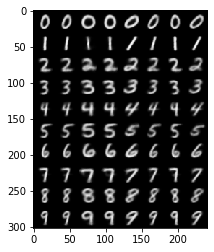

In [ ]:
plot_conditional_generation(model_C, n=8)

**Remark**: 

After 15 epochs, VAE vanilla arrives at a **Reconstruction loss around 80**; KL divergence around 25;

CVAE arrives at a larger Reconstruction loss around 140; a much smaller KL divergence around 1.5;

That's why CVAE has a better generation property (the latent variables z is really close to standard gaussian) than VAE. But we can imagine the reconstruction property of CVAE is worse than VAE. 